In [1]:
import os, sys, json, shapely
os.environ['USE_PYGEOS'] = '0'
from datetime import date, datetime
import pandas as pd; import numpy as np; import geopandas as gpd

In [2]:
FILE = 'youthmapper_changesets_latest.csv'

In [3]:
# Read and parse
sys.stderr.write("Loading File: "+ FILE)
df = pd.read_csv(FILE, parse_dates=['_day'], low_memory=False, dtype={'quadkey':str},
                 converters={'hashtags':lambda s: json.loads(s) if s!='' else '',
                             'tools':lambda s: json.loads(s) if s!='' else ''})
df['highways']      = df['new_highways']  + df['edited_highways']
df['buildings']     = df['new_buildings'] + df['edited_buildings']
df['amenities']     = df['new_amenities'] + df['edited_amenities']
df['all_feats']     = df['new_features']  + df['edited_features']
df['day'] = df._day

sys.stderr.write("\nRow Count: {:,}\n".format(len(df)))
sys.stderr.write("Latest Edit: {}\n".format(df._day.max()))
sys.stderr.write("Null Geometries: {}\n".format(len(df[pd.isnull(df.centroid)])))
pd.set_option('display.max_columns', 50)
df.head(1)

Loading File: youthmapper_changesets_latest.csv
Row Count: 517,900
Latest Edit: 2023-09-17 00:00:00
Null Geometries: 155


,_day,quadkey,centroid,convex_hull,new_highways,new_buildings,new_amenities,edited_highways,edited_buildings,edited_amenities,new_features,edited_features,edited_vertices,edited_elements,deleted_elements,deleted_nodes,sum_edits,arbitrary_changeset,sample_changeset_ids,changeset_count,min_lon,max_lon,min_lat,max_lat,total_area,tools,hashtags,uid,username,gender,chapter_id,alumni,steerco,regionalambassador,mentor,chapter,university,city,country,chapter_lon,chapter_lat,km_to_university,highways,buildings,amenities,all_feats,day
0,2023-09-17,210133132221202,POINT (-46.314913 -19.2022481),POINT (-46.314913 -19.2022481),12,0,0,1,0,0,12,1,0,1,0,0,60,141387335,[141387335],1,-46.321779,-46.308047,-19.207512,-19.196984,1.688050e+06,{'iD': 1},"[#teachosm-project-1463, #YouthMappers, #Youth...",20238991,Piucles,male,1018,NaN,NaN,NaN,NaN,YouthMappers UFV,Universidade Federal da Viçosa,Rio Paranaíba,Brazil,-46.224121,-19.219445,9.723322,13,0,0,13,2023-09-17


In [4]:
df = df[pd.notnull(df.centroid)]
df.centroid = df.centroid.apply(shapely.wkt.loads)
df.convex_hull = df.convex_hull.apply(shapely.wkt.loads)

In [5]:
def array_to_hist(arr):
    m = dict()
    for x in arr:
        if x in m:
            m[x] += 1
        else:
            m[x] = 1
    return m

In [6]:
#Create hashtag sets and make it a GeoDataFrame:
sys.stderr.write("Processing Lists of Hashtags, Timestamps, and Building GeoDataFrame...")
df['hashtags_list'] = df.hashtags.apply(array_to_hist)

df = gpd.GeoDataFrame(df, geometry='centroid')
df['timestamp'] = df.day.apply(lambda d: int(d.to_pydatetime().timestamp()))

sys.stderr.write("Done\n")
df[df.hashtags_list.apply(len)>0][['username','uid','day','timestamp','hashtags_list','centroid','quadkey']].head()


Processing Lists of Hashtags, Timestamps, and Building GeoDataFrame...Done


,username,uid,day,timestamp,hashtags_list,centroid,quadkey
0,Piucles,20238991,2023-09-17,1694923200,"{'#teachosm-project-1463': 1, '#YouthMappers':...",POINT (-46.31491 -19.20225),210133132221202
2,Pedroo_avl,20124812,2023-09-17,1694923200,"{'#teachosm-project-1463': 1, '#YouthMappers':...",POINT (-46.33582 -19.17922),210133132220132
3,Enoch Kojo Kondza,18443346,2023-09-17,1694923200,"{'#hotosm-project-15475': 1, '#moroccoearthqua...",POINT (-8.87811 30.48903),033130031032133
4,judithmurage,17275323,2023-09-17,1694923200,"{'#hotosm-project-15508': 1, '#krcs-elnino-map...",POINT (40.19607 0.43876),122333223023010
5,judithmurage,17275323,2023-09-17,1694923200,"{'#hotosm-project-15508': 2, '#krcs-elnino-map...",POINT (40.25262 -0.01563),300111001001113


In [7]:
print(f"Mappers Count: {df.uid.nunique()}, Chapter count: {df.chapter.nunique()}")

Mappers Count: 2628, Chapter count: 227


### Write Daily Editing CSV for Timeline: `data/daily_editing.csv`

In [8]:
# Create file for timeline
df.groupby('day').aggregate(
    {'all_feats':sum,
     'buildings':sum,
     'highways':sum,
     'amenities':sum,
     'new_features':sum,
     'uid':'nunique',
     'chapter':'nunique'}).rolling(7).mean().to_csv(
     '../activity-dashboard/data/daily_editing.csv'
)

### Write JSONP Files for Chapter Index: `data/chapters_and_uids.jsonp`

In [9]:
chapters = df.drop_duplicates(subset=['chapter_id'])[['chapter','chapter_id','city','country','university']]
chapters['Chapter Name'] = chapters.chapter
chapters.head(1)

,chapter,chapter_id,city,country,university,Chapter Name
0,YouthMappers UFV,1018,Rio Paranaíba,Brazil,Universidade Federal da Viçosa,YouthMappers UFV


In [10]:
with open('../activity-dashboard/data/chapters_and_uids.jsonp','w') as outFile:
    outFile.write( 'var chapters = ' + json.dumps(
        chapters.to_dict(orient='records'))+"\n")

In [11]:
sys.stderr.write("Quantifying All Hashtags...")
TAG_COUNTS = {}
for x in df.hashtags_list:
    for y in x:
        if y in TAG_COUNTS:
            TAG_COUNTS[y]+=x[y]
        else:
            TAG_COUNTS[y]=x[y]
tag_counts_df = pd.DataFrame.from_dict(TAG_COUNTS,orient='index', 
  columns=['count']).sort_values(by='count', ascending=False).reset_index().rename(columns={'index':'hashtag'})
sys.stderr.write("Done.\n")
display(tag_counts_df.head())

Quantifying All Hashtags...Done.


,hashtag,count
0,#YouthMappers,62496
1,#youthmappers,53097
2,#missingmaps,49576
3,#MissingMaps,38130
4,#Imagery4socialgood,23744


# Export Files for Graphs: `monthly_activity_*.json`

In [12]:
df['month'] = df.day.apply(lambda d: date(d.year, d.month,15))

In [13]:
_aggregations = {'new_buildings':sum,'new_highways':sum,'new_amenities':sum, 
     'edited_buildings':sum, 'edited_highways':sum, 'edited_amenities':sum,
     'uid':'nunique','chapter':'nunique'}

today      = datetime.now();
this_month = date(today.year, today.month, 1)

# All time:
monthly_activity_all_time = df[df.month < this_month].groupby('month').aggregate(_aggregations).rename(
columns={'uid':'users','chapter':'chapters'})

monthly_activity_all_time.reset_index(inplace=True)

# Write out all activity over time
monthly_activity_all_time.to_json('../activity-dashboard/data/monthly_activity_all_time.json',orient='records')

# Write out just last 1200 days activity
monthly_activity_all_time[monthly_activity_all_time.month > (this_month - 
                                 pd.Timedelta(days=1200))].to_json('../activity-dashboard/data/monthly_activity_last_1200_days.json',orient='records')
# Write out just last year's activity
monthly_activity_all_time[monthly_activity_all_time.month > (this_month - 
                                 pd.Timedelta(days=365))].to_json('../activity-dashboard/data/monthly_activity_last_year.json',orient='records')


<Axes: >

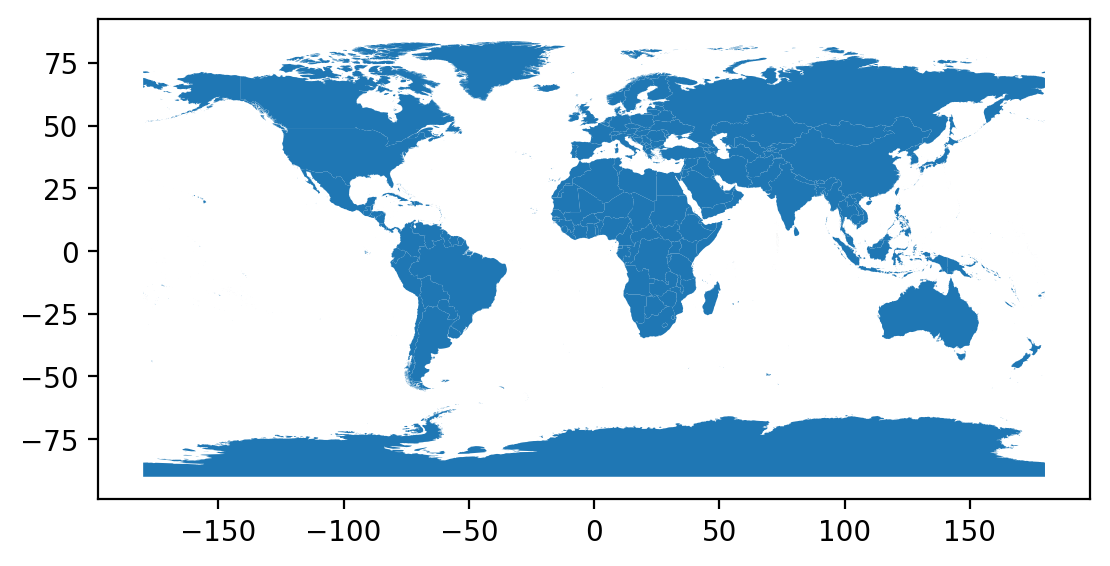

In [14]:
# Import country boundaries
countries = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')[
    ['NAME','ADM0_A3','CONTINENT','SUBREGION','geometry']
].rename(columns={'NAME':"edit_country","ADM0_A3":'edit_A3',"CONTINENT":'edit_continent','SUBREGION':'edit_subregion'})

countries.plot()

In [15]:
df_ = df.set_crs('EPSG:4326').sjoin(countries)
df_.head()

,_day,quadkey,centroid,convex_hull,new_highways,new_buildings,new_amenities,edited_highways,edited_buildings,edited_amenities,new_features,edited_features,edited_vertices,edited_elements,deleted_elements,deleted_nodes,sum_edits,arbitrary_changeset,sample_changeset_ids,changeset_count,min_lon,max_lon,min_lat,max_lat,total_area,...,chapter_id,alumni,steerco,regionalambassador,mentor,chapter,university,city,country,chapter_lon,chapter_lat,km_to_university,highways,buildings,amenities,all_feats,day,hashtags_list,timestamp,month,index_right,edit_country,edit_A3,edit_continent,edit_subregion
0,2023-09-17,210133132221202,POINT (-46.31491 -19.20225),POINT (-46.314913 -19.2022481),12,0,0,1,0,0,12,1,0,1,0,0,60,141387335,[141387335],1,-46.321779,-46.308047,-19.207512,-19.196984,1.688050e+06,...,1018,NaN,NaN,NaN,NaN,YouthMappers UFV,Universidade Federal da Viçosa,Rio Paranaíba,Brazil,-46.224121,-19.219445,9.723322,13,0,0,13,2023-09-17,"{'#teachosm-project-1463': 1, '#YouthMappers':...",1694923200,2023-09-15,44,Brazil,BRA,South America,South America
1,2023-09-17,210133132221313,POINT (-46.23753 -19.20625),POINT (-46.2375338 -19.2062527),0,1,0,2,0,0,1,2,0,2,0,0,6,141387569,[141387569],1,-46.240421,-46.234646,-19.211321,-19.201184,6.835427e+05,...,1018,NaN,NaN,NaN,NaN,YouthMappers UFV,Universidade Federal da Viçosa,Rio Paranaíba,Brazil,-46.224121,-19.219445,2.033536,2,1,0,3,2023-09-17,{},1694923200,2023-09-15,44,Brazil,BRA,South America,South America
2,2023-09-17,210133132220132,POINT (-46.33582 -19.17922),POINT (-46.3358189 -19.1792174),2,3,0,3,0,0,5,3,20,23,0,0,48,141380270,[141380270],1,-46.338844,-46.332794,-19.182417,-19.176018,4.521771e+05,...,1018,NaN,NaN,NaN,NaN,YouthMappers UFV,Universidade Federal da Viçosa,Rio Paranaíba,Brazil,-46.224121,-19.219445,12.553423,5,3,0,8,2023-09-17,"{'#teachosm-project-1463': 1, '#YouthMappers':...",1694923200,2023-09-15,44,Brazil,BRA,South America,South America
61,2023-09-17,210310032130310,POINT (-54.23964 -24.08677),POINT (-54.2396403 -24.0867658),0,0,0,0,11,0,0,11,0,11,0,0,11,141393729,[141393729],1,-54.240026,-54.239255,-24.087017,-24.086515,4.374853e+03,...,88,NaN,NaN,NaN,NaN,YouthMappers UNA,Universidad Nacional de Asunción,San Lorenzo,Paraguay,-57.560867,-25.312797,362.138387,0,11,0,11,2023-09-17,"{'#AUPy': 1, '#CIDI': 1}",1694923200,2023-09-15,44,Brazil,BRA,South America,South America
62,2023-09-17,210310032130311,POINT (-54.23804 -24.08787),POINT (-54.2380397 -24.0878653),0,2,0,0,89,0,2,89,24,140,27,22,159,141394924,[141394924],1,-54.239511,-54.236568,-24.089201,-24.086529,8.874170e+04,...,88,NaN,NaN,NaN,NaN,YouthMappers UNA,Universidad Nacional de Asunción,San Lorenzo,Paraguay,-57.560867,-25.312797,362.240833,0,91,0,91,2023-09-17,"{'#AUPy': 1, '#CIDI': 1}",1694923200,2023-09-15,44,Brazil,BRA,South America,South America


# Export Top Edited Countries: `top_edited_countries.json`

In [16]:
top_edited_countries = []

for month, rows in df_[df_.month > this_month - pd.Timedelta(days=90)].groupby('month'):
    t15 = rows.groupby('edit_country').aggregate({'all_feats':sum}).sort_values(by='all_feats',ascending=False).head(15)
    
    top_edited_countries.append({'month': month.isoformat(), 'top_countries': list(zip(list(t15.index), list(t15.all_feats)))})
    
json.dump(top_edited_countries, open('../activity-dashboard/data/top_edited_countries.json','w'))
          

In [17]:
# Which chapters are active in the most edited countries?
top_country = top_edited_countries[-1].get('top_countries')[0][0]
df_[df_.edit_country==top_country].groupby('chapter').aggregate(
    {'uid':'nunique','all_feats':'sum'}
        ).sort_values(by='all_feats', ascending=False).head()

,uid,all_feats
chapter,,
Good Mappers,7,145530
Mappers for Life,1,39442
Association of Geomatics Engineering Students,6,31124
Polimappers,9,28746
SMCoSE YouthMappers,9,26248


### Local Editing?

In [18]:
top_chapters = df_[df_.day > pd.Timestamp('20220101')].groupby('edit_continent').aggregate(
    {'all_feats':sum}).sort_values(by='all_feats', ascending=False).head(5).index.values

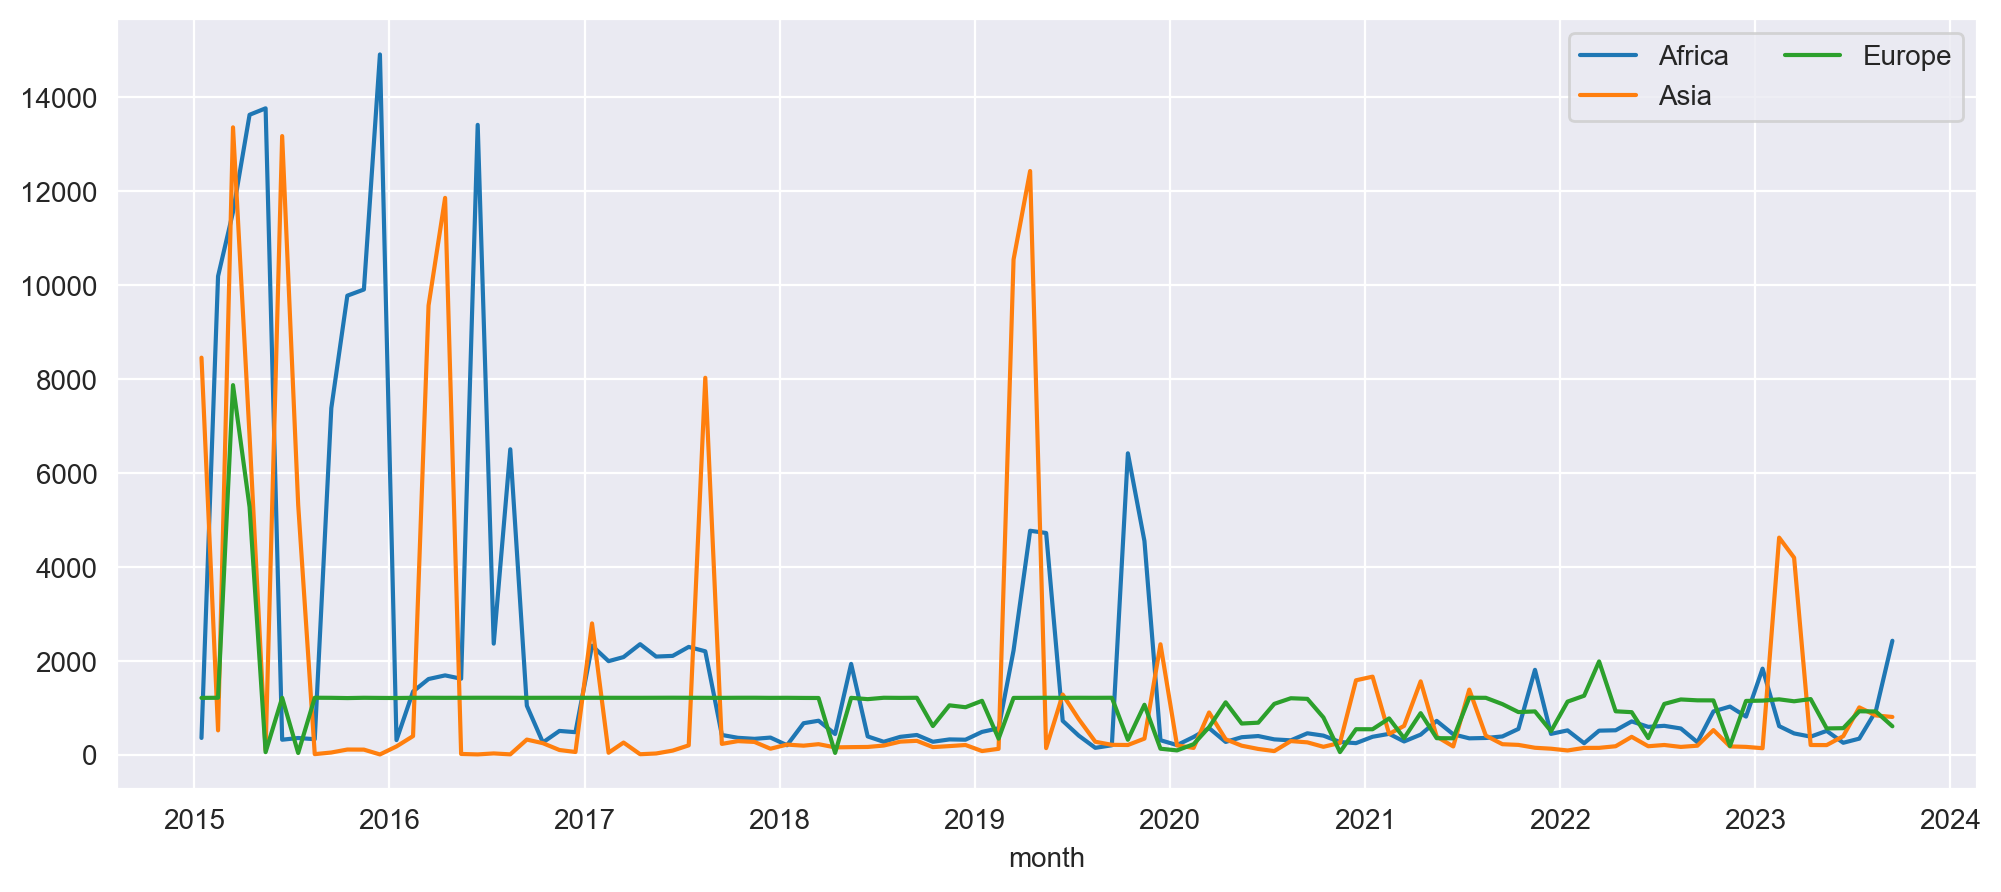

In [19]:
import seaborn as sns
sns.set_style("darkgrid")
ax = df_.groupby(['month','edit_continent']).aggregate(
    {'km_to_university':'median'}
).unstack().km_to_university[
    ['Africa','Asia','Europe']].plot(figsize=(12,5))
ax.legend(loc='best',ncol=2)
ax.set_ylabel("Median distance (km) from home\nUniversity that YouthMappers are editing.", fontsize=16)
ax.set_ylabel(None);

## Downscale for lower zoom levels:

In [20]:
sys.stderr.write("Downscaling to Z10...")
df_['z10'] = df_.quadkey.apply(lambda q: q[:10])
gb_z10 = df_.groupby(['z10','day','uid']).aggregate({'username':max, 'chapter_id':max, 'timestamp':max,
     'hashtags_list':list, 'centroid':list, 'all_feats':sum, 'new_features':sum, 'edited_features':sum,
     'new_buildings':sum,'new_amenities':sum,'new_highways':sum,
     'edited_buildings':sum,'edited_amenities':sum,'edited_highways':sum})
sys.stderr.write("Done\nZ10 row count: {:,}".format(len(gb_z10)))
gb_z10.head(2)

Downscaling to Z10...Done
Z10 row count: 177,591

,,,username,chapter_id,timestamp,hashtags_list,centroid,all_feats,new_features,edited_features,new_buildings,new_amenities,new_highways,edited_buildings,edited_amenities,edited_highways
z10,day,uid,,,,,,,,,,,,,,
0023022030,2020-08-10,8309360,Lamichhane,1098,1597032000,"[{'#MappingBajhangBajura': 1, '#NAXA': 1, '#Yo...",[POINT (-156.7623209 71.2966706)],1,1,0,0,0,1,0,0,0
0031011203,2023-07-19,1770239,Jennings Anderson,1,1689739200,[{}],[POINT (-103.514109 78.7866658)],0,0,0,0,0,0,0,0,0


In [21]:
sys.stderr.write("Downscaling to Z8...")
df_['z8'] = df_.quadkey.apply(lambda q: q[:8])
gb_z8 = df_.groupby(['z8','day','uid']).aggregate({'username':max, 'chapter_id':max, 'timestamp':max,
     'hashtags_list':list, 'centroid':list, 'all_feats':sum, 'new_features':sum, 'edited_features':sum,
     'new_buildings':sum,'new_amenities':sum,'new_highways':sum,
     'edited_buildings':sum,'edited_amenities':sum,'edited_highways':sum})
sys.stderr.write("Done\nZ8 row count: {:,}".format(len(gb_z8)))
gb_z8.head(2)

Downscaling to Z8...Done
Z8 row count: 143,477

,,,username,chapter_id,timestamp,hashtags_list,centroid,all_feats,new_features,edited_features,new_buildings,new_amenities,new_highways,edited_buildings,edited_amenities,edited_highways
z8,day,uid,,,,,,,,,,,,,,
00230220,2020-08-10,8309360,Lamichhane,1098,1597032000,"[{'#MappingBajhangBajura': 1, '#NAXA': 1, '#Yo...",[POINT (-156.7623209 71.2966706)],1,1,0,0,0,1,0,0,0
00310112,2023-07-19,1770239,Jennings Anderson,1,1689739200,[{}],[POINT (-103.514109 78.7866658)],0,0,0,0,0,0,0,0,0


## Create per-chapter GeoJSON features

In [22]:
daily_chapter_activity = df_.groupby(['z8','day','chapter']).aggregate(
    {'amenities':sum,'buildings':sum,'highways':sum,'all_feats':sum,'centroid':list,
     'uid':'nunique'}
)

In [23]:
daily_chapter_activity['geojson'] = daily_chapter_activity.centroid.apply(
    lambda l: shapely.geometry.mapping(shapely.geometry.MultiPoint(l).centroid))

daily_chapter_activity['geometry'] = daily_chapter_activity.geojson.apply(lambda g: 
    {"type":"Point",
     "coordinates": list(np.round(np.array(g['coordinates']),6))})
daily_chapter_activity.head(2)

,,,amenities,buildings,highways,all_feats,centroid,uid,geojson,geometry
z8,day,chapter,,,,,,,,
00230220,2020-08-10,Geomatics Engineering Students Association of Nepal,0,0,1,1,[POINT (-156.7623209 71.2966706)],1,"{'type': 'Point', 'coordinates': (-156.7623209...","{'type': 'Point', 'coordinates': [-156.762321,..."
00310112,2023-07-19,Good Mappers,0,0,0,0,[POINT (-103.514109 78.7866658)],1,"{'type': 'Point', 'coordinates': (-103.514109,...","{'type': 'Point', 'coordinates': [-103.514109,..."


# Write out daily chapter activity: `daily_chapter_activity.geojson`

In [24]:
with open('../activity-dashboard/data/daily_chapter_activity.geojson','w') as outFile:
    outFile.write('{"type":"FeatureCollection",\n "features":[\n')
    rows = 0
    total = len(daily_chapter_activity)
    for (quadkey, day, chapter), row in daily_chapter_activity.iterrows():
        rows+=1
        feat = {"type":"Feature",
                "properties": {
                    'date'     : "{}-{}-{}".format(day.year,day.month,day.day),
                    'chapter'  : chapter,
                    'highways' : row.highways,
                    'buildings': row.buildings,
                    'amenities': row.amenities,
                    'other'    : row.all_feats - row.highways - row.buildings - row.amenities,
                    'mappers'  : row.uid
                },
                "geometry":row.geometry}
        
        if rows < total:
            outFile.write("  " + json.dumps(feat)+",\n")
        else:
            outFile.write("  " + json.dumps(feat)+"\n ]\n}")

# Prepare Feature Exports for TippeCanoe

In [25]:
#Output Variables
HASHTAG_THRESHOLD = 10
OUTPUT_ROWS = ['uid','chapter_id','timestamp','all_feats','amenities','buildings','highways']

In [26]:
def build_feature_from_low_zoom_agg(key, row, layer_id, minzoom, maxzoom):
    #Calculate the new centroid
    centroid   = shapely.geometry.MultiPoint(row.centroid).centroid
    centroid_geojson = shapely.geometry.mapping(centroid)
    centroid_geojson['coordinates'] = list(np.round(np.array(centroid_geojson['coordinates']),8))
    
    feature = {'type':'Feature',
               'properties': {
                   'uid':key[2]
               },
               'geometry': centroid_geojson,
               'tippecanoe':{
                   'layer' : layer_id,
                   'minzoom':minzoom,
                   'maxzoom':maxzoom
               }}
    for r in OUTPUT_ROWS:
        if r in row:
            feature['properties'][r] = row[r]
    return feature

# Heavy Lifting Row Iterator to Write GeoJSON Features: `all_youthmappers_changesets_*.geojsonseq`

In [27]:
line_count=0;
HEAD = None
with open('geojson/all_youthmappers_changesets_z8.geojsonseq','w') as output_geojson:
    
    # First do the z8 aggregation
    for key, row in gb_z8.head(HEAD).iterrows():
        feat = build_feature_from_low_zoom_agg(key, row, 'z8agg',2,2)

        if line_count==0:
            sys.stderr.write("Beginning Z8, First Feature: \n"+json.dumps(feat)+"\n")
        
        output_geojson.write( json.dumps(feat) +"\n")
        line_count+=1;

        if line_count %5000==0:
            sys.stderr.write("\r{:,} / {:,} features written".format(line_count, len(gb_z8)))
    
    sys.stderr.write("\nFinished z8 Aggregation, beginning z10:\n")
    line_count=0;
    
with open('geojson/all_youthmappers_changesets_z10.geojsonseq','w') as output_geojson:
    for key, row in gb_z10.head(HEAD).iterrows():
        feat = build_feature_from_low_zoom_agg(key, row, 'z10agg',3,5)

        if line_count==0:
            sys.stderr.write("First Feature: \n"+json.dumps(feat)+"\n")
        
        output_geojson.write( json.dumps(feat) +"\n")
        line_count+=1;

        if line_count %5000==0:
            sys.stderr.write("\r{:,} / {:,} features written".format(line_count, len(gb_z10)))
 
    sys.stderr.write("\nFinished z10 Aggregation, beginning z15:\n")
    line_count=0;

with open('geojson/all_youthmappers_changesets_z15.geojsonseq','w') as output_geojson:
    for idx, row in df.head(HEAD).iterrows():
        feature = {'type':'Feature',
                   'properties': dict(row[OUTPUT_ROWS]),
                   'geometry': shapely.geometry.mapping(row.centroid),
                   'tippecanoe':{
                       'layer' : 'z15agg',
                       'minzoom':6,
                       'maxzoom':10
                   }}
                    
        if line_count==0:
            sys.stderr.write("First Feature: \n"+json.dumps(feature)+"\n")

        output_geojson.write( json.dumps(feature) +"\n")
        line_count+=1;
        if line_count %5000==0:
            sys.stderr.write("\r{:,} / {:,} features written".format(line_count, len(df)))
    sys.stderr.write("\n\nFinished z15 circle Aggregation, beginning z15 Poly:\n")
    line_count=0;

with open('geojson/all_youthmappers_changesets_z15_bboxes.geojsonseq','w') as output_geojson:
    for idx, row in df.head(HEAD).iterrows():
        feature = {'type':'Feature',
                   'properties': dict(row[OUTPUT_ROWS]),
                   'geometry': {'type':'LineString','coordinates':[
                       [row.min_lon, row.min_lat],
                       [row.min_lon, row.max_lat],
                       [row.max_lon, row.max_lat],
                       [row.max_lon, row.min_lat],
                       [row.min_lon, row.min_lat]]},
                   'tippecanoe':{
                       'layer' : 'z15agg_bbox',
                       'minzoom':10,
                       'maxzoom':10
                   }}
                    
        if line_count==0:
            sys.stderr.write("First Feature: \n"+json.dumps(feature)+"\n")

        output_geojson.write( json.dumps(feature) +"\n")
        line_count+=1;
        if line_count %5000==0:
            sys.stderr.write("\r{:,} / {:,} features written".format(line_count, len(df)))
sys.stderr.write("\nDone. Now run: \n\n\ttippecanoe -B1 -Z1 -z10 -fP -o ym_changesets.mbtiles all_youthmappers_changesets_*.geojsonseq")

Beginning Z8, First Feature: 
{"type": "Feature", "properties": {"uid": 8309360, "chapter_id": 1098, "timestamp": 1597032000, "all_feats": 1}, "geometry": {"type": "Point", "coordinates": [-156.7623209, 71.2966706]}, "tippecanoe": {"layer": "z8agg", "minzoom": 2, "maxzoom": 2}}
140,000 / 143,477 features written
Finished z8 Aggregation, beginning z10:
First Feature: 
{"type": "Feature", "properties": {"uid": 8309360, "chapter_id": 1098, "timestamp": 1597032000, "all_feats": 1}, "geometry": {"type": "Point", "coordinates": [-156.7623209, 71.2966706]}, "tippecanoe": {"layer": "z10agg", "minzoom": 3, "maxzoom": 5}}
175,000 / 177,591 features written
Finished z10 Aggregation, beginning z15:
First Feature: 
{"type": "Feature", "properties": {"uid": 20238991, "chapter_id": 1018, "timestamp": 1694923200, "all_feats": 13, "amenities": 0, "buildings": 0, "highways": 13}, "geometry": {"type": "Point", "coordinates": [-46.314913, -19.2022481]}, "tippecanoe": {"layer": "z15agg", "minzoom": 6, "max

112

<br>
<br>
<hr>

# MEL Reporting Requirements

In [28]:
df_['month'] = df_.day.apply(lambda d: date(d.year, d.month, 15))
df.head(2)

,_day,quadkey,centroid,convex_hull,new_highways,new_buildings,new_amenities,edited_highways,edited_buildings,edited_amenities,new_features,edited_features,edited_vertices,edited_elements,deleted_elements,deleted_nodes,sum_edits,arbitrary_changeset,sample_changeset_ids,changeset_count,min_lon,max_lon,min_lat,max_lat,total_area,tools,hashtags,uid,username,gender,chapter_id,alumni,steerco,regionalambassador,mentor,chapter,university,city,country,chapter_lon,chapter_lat,km_to_university,highways,buildings,amenities,all_feats,day,hashtags_list,timestamp,month
0,2023-09-17,210133132221202,POINT (-46.31491 -19.20225),POINT (-46.314913 -19.2022481),12,0,0,1,0,0,12,1,0,1,0,0,60,141387335,[141387335],1,-46.321779,-46.308047,-19.207512,-19.196984,1.688050e+06,{'iD': 1},"[#teachosm-project-1463, #YouthMappers, #Youth...",20238991,Piucles,male,1018,NaN,NaN,NaN,NaN,YouthMappers UFV,Universidade Federal da Viçosa,Rio Paranaíba,Brazil,-46.224121,-19.219445,9.723322,13,0,0,13,2023-09-17,"{'#teachosm-project-1463': 1, '#YouthMappers':...",1694923200,2023-09-15
1,2023-09-17,210133132221313,POINT (-46.23753 -19.20625),POINT (-46.2375338 -19.2062527),0,1,0,2,0,0,1,2,0,2,0,0,6,141387569,[141387569],1,-46.240421,-46.234646,-19.211321,-19.201184,6.835427e+05,{'iD': 1},[],20238991,Piucles,male,1018,NaN,NaN,NaN,NaN,YouthMappers UFV,Universidade Federal da Viçosa,Rio Paranaíba,Brazil,-46.224121,-19.219445,2.033536,2,1,0,3,2023-09-17,{},1694923200,2023-09-15


In [29]:
df_.gender = df_.gender.fillna('').apply(lambda s: s.lower())

<Axes: xlabel='month'>

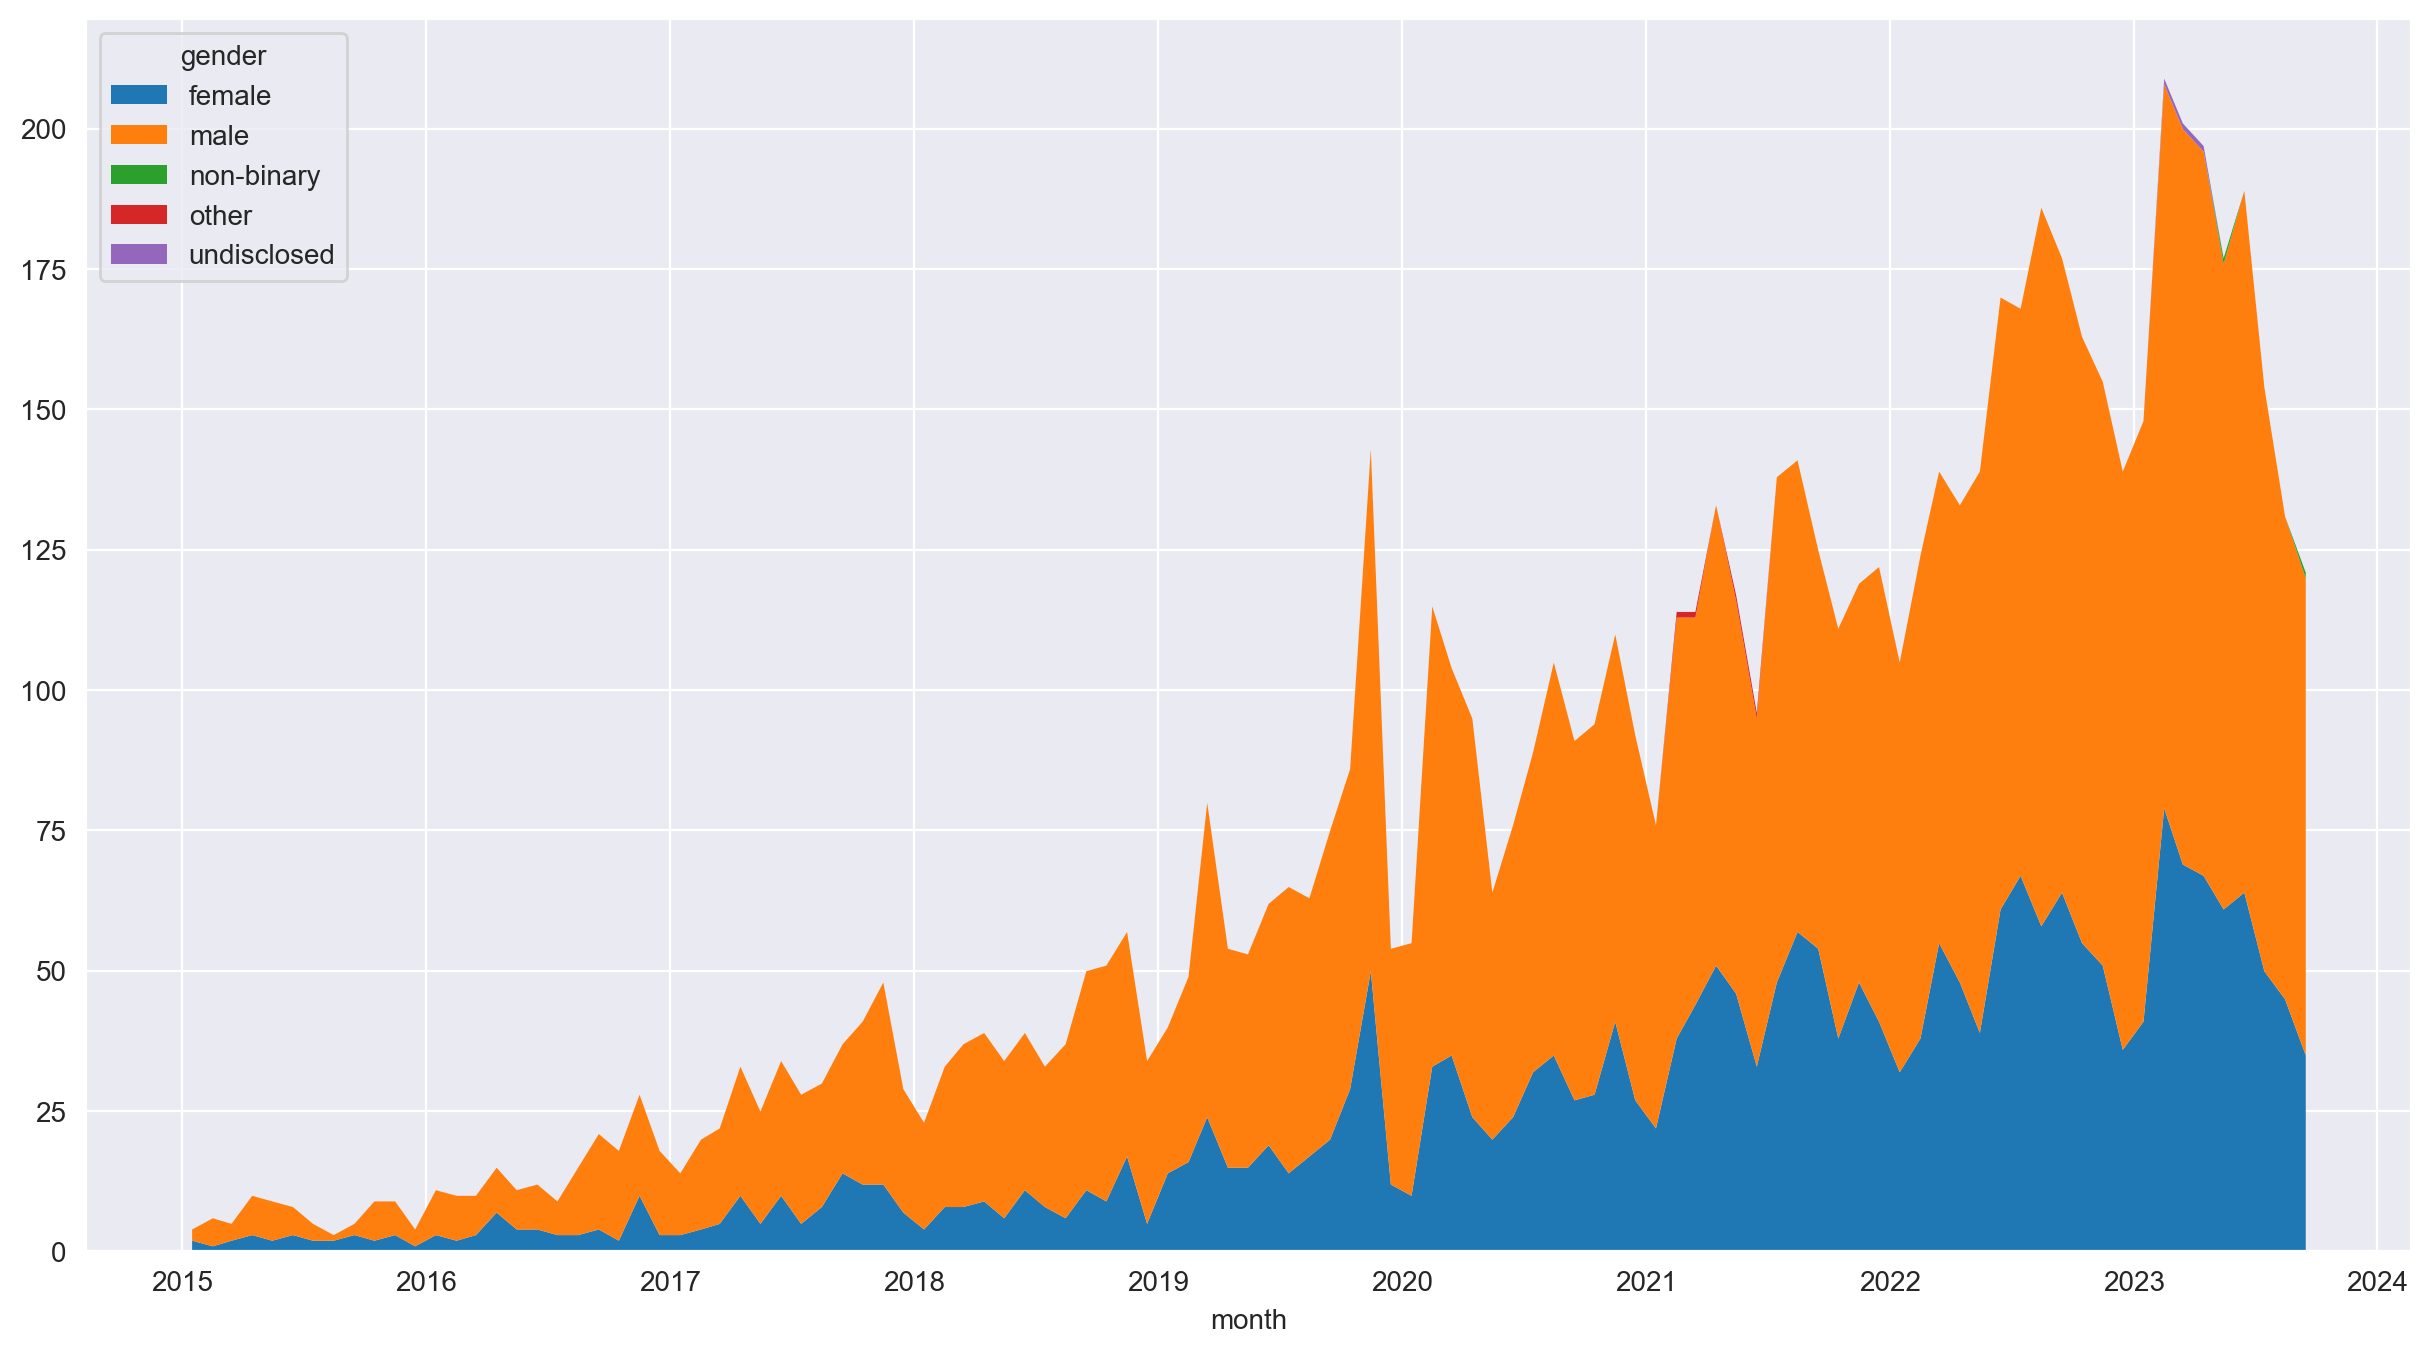

In [30]:
gb_month_gender = df_[df_.gender != ''].groupby(['month','gender']).aggregate({
    'uid':'nunique', 
    'chapter_id':'nunique',
    'highways':sum, 
    'buildings':sum,
    'amenities':sum, 
    'all_feats':sum 
})

gb_month_gender.unstack().uid.plot.area(stacked=True, lw=0, figsize=(15,8))
                                           

In [31]:
gb_month_gender.rename(columns={'uid':'mappers','chapter_id':'chapters'}).to_csv('mappers_per_month_with_gender.csv')

<br><br>
<hr>
<br><br>

# Summary Stats and Visualizations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [ ]:
df.hashtags_list = df.hashtags_list.apply(set)

In [ ]:
print("Overall, our dataset contains {:,} known YouthMapper usernames from {:,} chapters that have made at least 1 edit in OSM".format(
    df.uid.nunique(), df.chapter.nunique())
)

## Time Bounded

In [ ]:
START_DATE  = pd.Timestamp('2022-01-01')
END_DATE    = pd.Timestamp('2023-01-01')

In [ ]:
_slice = df[ (df.day >= START_DATE) & 
             (df.day  < END_DATE) ]
print("In this time slice, we saw:\n\t{:,} Distinct YouthMappers from \n\t{:,} Chapters".format(
    _slice.uid.nunique(),_slice.chapter.nunique()))
first_edits = df.groupby('uid').aggregate({'day':min}).reset_index()
print("\t{} of these mappers made their first edit.".format(len(
    first_edits[(first_edits.day >= START_DATE) & (first_edits.day < END_DATE)])))

In [ ]:
print("New Objects:\n\tBuildings: {:,}\n\tHighways:  {:,}\n\tAmenities: {:,}\n\tOther:     {:,}".format(
    _slice.new_buildings.sum(), _slice.new_highways.sum(), _slice.new_amenities.sum(),
    _slice.new_features.sum() - (_slice.new_buildings.sum()+_slice.new_highways.sum()+_slice.new_amenities.sum())))
print("===========================")
print("Edited Objects:\n\tBuildings: {:,}\n\tHighways:  {:,}\n\tAmenities: {:,}\n\tOther:     {:,}".format(
    _slice.edited_buildings.sum(), _slice.edited_highways.sum(), _slice.edited_amenities.sum(),
    _slice.edited_features.sum() - (_slice.edited_buildings.sum()+_slice.edited_highways.sum()+_slice.edited_amenities.sum())))
# print("\nDeleted Objects:   {:,}".format(_slice.deleted_features.sum()))

## Top Chapters

In [ ]:
top_chaps = _slice.groupby('chapter').aggregate(
    {'uid':'nunique',
     'new_features': sum,
     'edited_features': sum,
     'sum_edits': sum,
     'changeset_count': sum,
     'all_feats': sum,
     'highways': sum,
     'buildings': sum,
     'amenities': sum}).sort_values(by='all_feats', ascending=False).rename(
    columns={'uid':"Mappers"})
top_chaps.to_csv('mapper_data/2022_statistics.csv')

top_chaps.sum()

## Per Continent Stats?

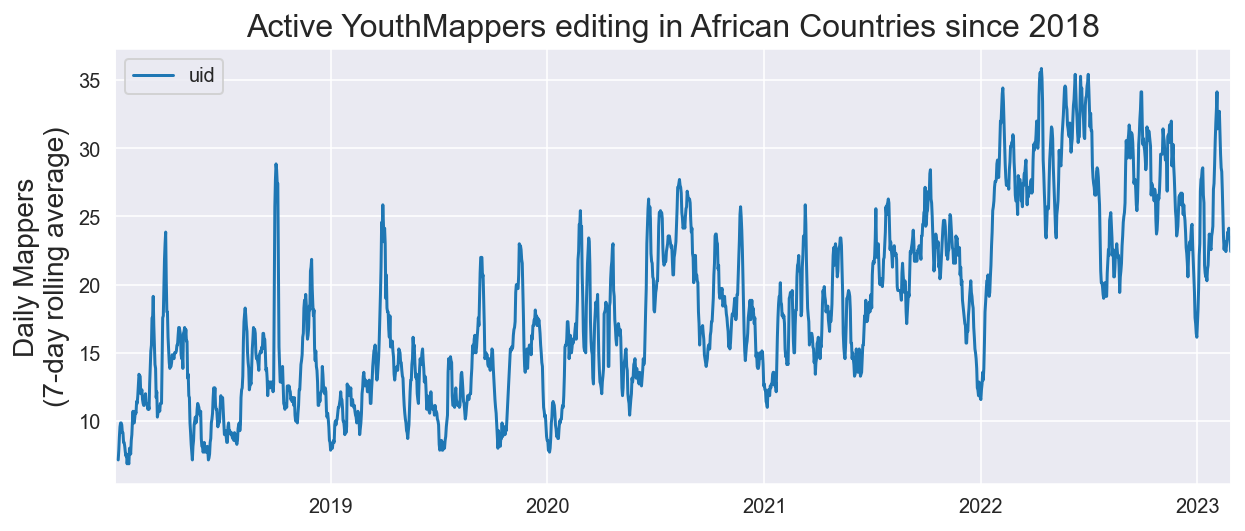

In [44]:
ax = df_[(df_.edit_continent=='Africa') & 
         (df_._day>datetime(2018,1,1,0,0,0))
        ].groupby('_day').aggregate({'uid':'nunique'}).sort_index().rolling(7).mean().plot(figsize=(10,4))
ax.set_title("Active YouthMappers editing in African Countries since 2018", fontsize=16)
ax.set_ylabel("Daily Mappers\n(7-day rolling average)", fontsize=14); ax.set_xlabel(None);

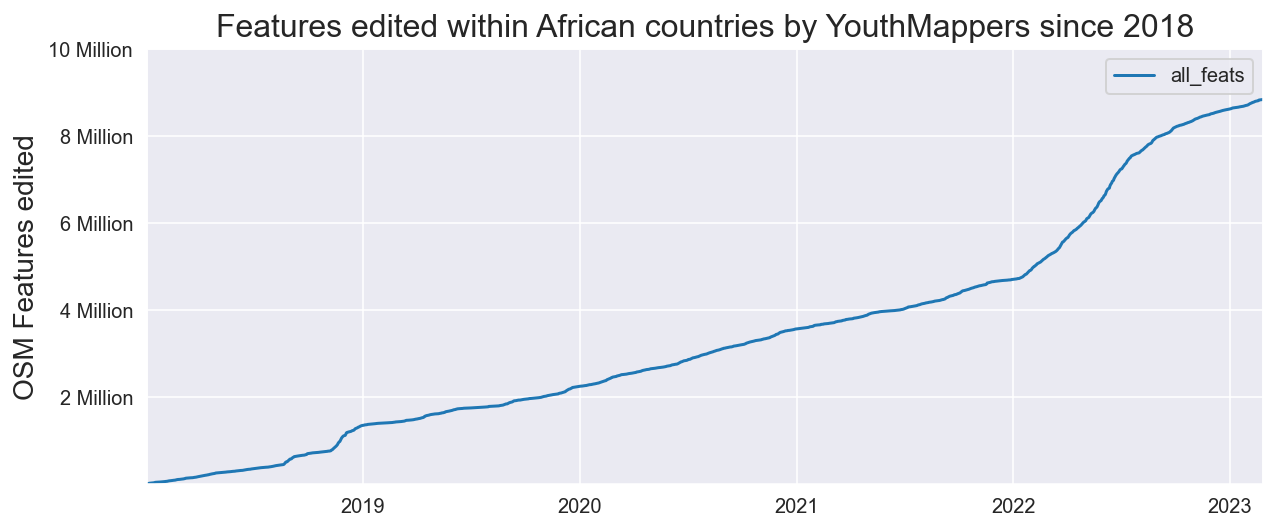

In [51]:
ax = df_[(df_.edit_continent=='Africa') & 
         (df_._day>datetime(2018,1,1,0,0,0))
        ].groupby('_day').aggregate({'all_feats':sum}).sort_index().cumsum().plot(figsize=(10,4))
ax.set_title("Features edited within African countries by YouthMappers since 2018", fontsize=16)
ax.set_ylabel("OSM Features edited", fontsize=14); ax.set_xlabel(None);
ax.yaxis.set_major_formatter(lambda x, pos: "{} Million".format(int(x/1000000)))
ax.set_ylim(1,10000000);

In [ ]:
print("Top 15 Countries by New Features Count")
aggregators = {'new_features':sum,'new_buildings':sum, 'new_highways':sum, 'new_amenities':sum, 
        'edited_features':sum, 'chapter':'nunique', 'uid':'nunique'}
_slice.groupby('country').aggregate(aggregators
    ).sort_values(by='new_features',ascending=False).head(15).rename(columns={'chapter':"# Chapters",'uid':"# Mappers"})


In [ ]:
ax = _slice.plot(column='new_features',cmap='viridis', figsize=(15,8), s=np.log1p(_slice.all_feats))
ax.set_title("Edit Concentration this quarter")

In [ ]:
df['month'] = df.day.apply(lambda d: date(d.year, d.month, 15))
gb_month = df.groupby('month').aggregate(aggregators)

In [ ]:
sns.set_style('darkgrid')
ax = gb_month['new_features'].plot(figsize=(15,8))
ax.set_title("New Features Added Each Month (Globally)", fontsize=20)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(lambda x, pos: "{:,}".format(int(x)))

In [ ]:
sns.set_style('darkgrid')
ax = gb_month['edited_features'].plot(figsize=(15,8))
ax.set_title("Features Edited Each Month (Globally)", fontsize=20)
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(lambda x, pos: "{:,}".format(int(x)))

In [ ]:
_slice.edited_buildings.sum(), _slice.new_buildings.sum()

In [ ]:
_slice.chapter.unique()

In [ ]:
days_per_mapper = df.groupby('uid').aggregate({'day':'nunique'}).reset_index()
active_contributors = days_per_mapper[days_per_mapper.day>=42].uid

print("There are {} _active contributors_ in YouthMappers (mapped for at least 42 days)".format(len(active_contributors)))
print("{} of these mappers were active in this time slice".format(_slice[_slice.uid.isin(active_contributors)].uid.nunique()))

In [ ]:
by_subregion = _slice.groupby('subregion').aggregate(
    {'uid':'nunique','chapter':'nunique','all_feats':sum}
).sort_values(by='all_feats',ascending=False).rename(
    columns={'uid':"YouthMappers",'chapter':"Chapters",'all_feats':'Features'})
by_subregion.head(15)

In [ ]:
df['year'] = df.day.apply(lambda d: d.year)
df.head(2)

In [ ]:
df['month'] = df.day.apply(lambda d: date(d.year, d.month, 1))

In [ ]:
sns.set_style('darkgrid')
ax = df.groupby('month').aggregate({'chapter':'nunique'}).rolling(7).mean().plot(figsize=(15,8), legend=None)
ax.set_xlabel(None);
ax.set_title("Number of Distinct Chapters Active Each Month", fontsize=24)

In [ ]:
sns.set_style('darkgrid')
ax = df.groupby('month').aggregate({'uid':'nunique'}).rolling(7).mean().plot(figsize=(15,8), legend=None)
ax.set_xlabel(None);
ax.set_title("Number of Distinct Mappers Active Each Month", fontsize=24)

In [ ]:
with open('changesets_by_year.geojson','w') as outFile:
    outFile.write(df[['year','centroid','all_feats','username']].to_json())

In [ ]:
# Top Edited Countries by User count: 
hashtags_used = _slice.groupby('chapter').aggregate({'uid':'nunique',
                                     'country':'nunique',
                                     'all_feats':sum,
                                     'hashtags_list':lambda a: set.union(*a)}
    ).sort_values(by='all_feats',ascending=False).rename(columns={
         'uid':'Mappers','country':'Countries Edited','all_feats':'Total features'})
hashtags_used['Distinct Hashtags Used'] = hashtags_used.hashtags_list.apply(len)
hashtags_used.head(10)

In [ ]:
country_geoms = gpd.read_file('/Users/jenningsanderson/various-osm/data/countries.geojson').set_index('ADMIN')

In [ ]:
# Top Edited Countries by feature
countries = _slice.groupby('country').aggregate(
        {'all_feats':'sum','chapter':set}
).sort_values(by='all_feats',ascending=False)
display(countries.head(10))
list(countries.head(2).chapter)

In [ ]:
countries

In [ ]:
from matplotlib import colors

In [ ]:
country_geoms.join(countries).plot(column='all_feats', cmap='Greens', figsize=(15,10))

In [ ]:
country_geoms.join(countries).plot(column='all_feats', cmap='Greens', figsize=(15,10), 
                                   norm=colors.LogNorm(vmin=countries.all_feats.min(), vmax=countries.all_feats.max(), ))

In [ ]:
_slice[_slice.country=='Afghanistan'].groupby('chapter').aggregate({'all_feats':sum}).sort_values(by='all_feats',ascending=False)

In [ ]:
hashtags = _slice[_slice.country=='Afghanistan'].groupby('chapter').aggregate(
    {'all_feats':sum, 'hashtags_list':lambda a: set.union(*a)
}).sort_values(by='all_feats',ascending=False)
hashtags.head()

In [ ]:
list(hashtags.hashtags_list)

In [ ]:
with open('2021_q2.geojson','w') as output:
    output.write(_slice[['highways','buildings','amenities','all_feats','sum_edits','uid','chapter','centroid','timestamp']].to_json())